In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
#torch.multiprocessing.set_start_method('spawn')
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import ConcatDataset, DataLoader
from catalyst import dl
from catalyst.utils import metrics
from torch.nn import functional as F
from catalyst.dl import AlchemyLogger

import vxs

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [2]:
if torch.cuda.is_available():
    print(torch.cuda.current_device())

In [3]:
PAD_TRACK_LEN = 4096*4
CUT_FRAME_WINDOW = 4096*4
PAD_SPECGRAM = PAD_TRACK_LEN // 512

vocal_sketch_dataset = vxs.SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'),
                                     pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM)
drum_machines_dataset = vxs.SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'),
                                      pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM)
avp_set_fixed = vxs.SampleSet(tracks=vxs.SegmentSet(vxs.AVPTrackSet('../data/AVP_Dataset', subset='Fixed'),
                                                    frame_window=CUT_FRAME_WINDOW, return_class=False),
                              pad_track=PAD_TRACK_LEN, pad_specgram=PAD_SPECGRAM)
common_set = ConcatDataset([vocal_sketch_dataset, drum_machines_dataset, avp_set_fixed])

In [4]:
len(common_set)

15995

In [5]:
len(drum_machines_dataset)

6749

In [6]:
len(vocal_sketch_dataset)

4429

In [7]:
%%time
# Pre-caching all the specgrams
for i in tqdm(range(len(common_set))):
    _ = common_set[i]

100%|██████████| 15995/15995 [02:11<00:00, 121.18it/s]

CPU times: user 4min 19s, sys: 3min 23s, total: 7min 43s
Wall time: 2min 11s


In [8]:
class ConvAERunner(dl.Runner):
    def _handle_batch(self, batch):
        x = batch          # ignore the raw waveform
        y, z = self.model(x)
        loss = F.mse_loss(y, x)
        self.batch_metrics = {
            'loss': loss
        }
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
def alchemy_logger(group, name):
    return AlchemyLogger(
        token="1da39325aff8856a81d7ad0250c9f921",
        project="default",
        experiment=name,
        group=group,
        log_on_epoch_end=False
    )

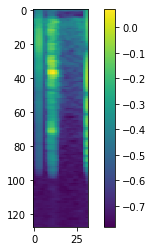

torch.Size([128, 32])


In [9]:
def sample_random(num, ln, seed):
    np.random.seed(seed)
    return np.random.randint(0, ln, size=num)

def imshow_random_samples(dataset, num, random_seed=42, cols=3):
    samples = sample_random(num, len(dataset), random_seed)
    rows = num // cols + (0 if num % cols == 0 else 1)
    fig, axes_t = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = [ax for tp in axes_t for ax in tp]
    
    for (sample_idx, ax) in zip(samples, axes):
        sample = dataset[sample_idx]
        ax.imshow(sample.cpu().squeeze(0).numpy())
        ax.set_title(sample_idx)
        
    plt.show()
    
def imshow_ae_output(model, dataset, num, random_seed=42):
    samples = sample_random(num, len(dataset), random_seed)
    fig, axes = plt.subplots(num, 3, figsize=(12, 4*num))
    
    for (sample_idx, (ax1, ax2, ax3)) in zip(samples, axes):
        sample = dataset[sample_idx].cpu()
        sample_out, z = model(sample.unsqueeze(0))
        ax1.imshow(sample.squeeze().numpy())
        ax2.imshow(sample_out.detach().squeeze().numpy())
        ax3.imshow(z.detach().squeeze().numpy().reshape(16, -1))
        
    plt.show()
    
melgram = common_set[42][0]
im = plt.imshow(melgram.cpu().squeeze(0).numpy())
plt.colorbar(im)
plt.show()
print(melgram.shape)

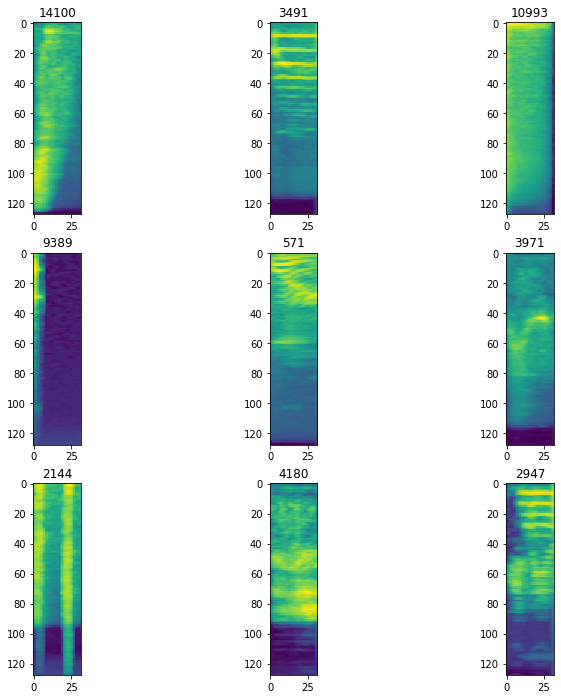

In [10]:
imshow_random_samples(common_set, 9, random_seed=44, cols=3)

In [11]:
splitter = vxs.DataSplit(common_set, shuffle=True, test_train_split=1)
loaders = {
    'train': splitter.get_train_loader(),
    'valid': splitter.get_validation_loader()
}

model = vxs.ConvAE(padding_mode='zeros')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
#model.load_state_dict(torch.load('../logs/conv_ae_fixed_2/checkpoints/best.pth')['model_state_dict'])

In [13]:
#model.eval()
#imshow_ae_output(model, common_set, 10, random_seed=455)

In [21]:
runner = ConvAERunner()
runner.train(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_fixed_2_tmp"
)


1/10 * Epoch (train):   0% 0/282 [00:00<?, ?it/s]
1/10 * Epoch (train):   0% 0/282 [00:01<?, ?it/s, loss=0.698]
1/10 * Epoch (train):   0% 1/282 [00:01<04:53,  1.04s/it, loss=0.698]
1/10 * Epoch (train):   0% 1/282 [00:01<04:53,  1.04s/it, loss=0.529]
1/10 * Epoch (train):   1% 2/282 [00:01<04:37,  1.01it/s, loss=0.529]
1/10 * Epoch (train):   1% 2/282 [00:02<04:37,  1.01it/s, loss=0.578]
1/10 * Epoch (train):   1% 3/282 [00:02<04:26,  1.05it/s, loss=0.578]
1/10 * Epoch (train):   1% 3/282 [00:03<04:26,  1.05it/s, loss=0.452]
                                                 .08it/s, loss=0.452]
                                                                  Early exiting
1/20 * Epoch (train):   0% 0/282 [01:59<?, ?it/s]
1/10 * Epoch (train):   1% 4/282 [00:03<04:18,  1.08it/s, loss=0.452]

In [ ]:
#model.eval()
#imshow_ae_output(model, vocal_sketch_dataset, 10, random_seed=44)

In [12]:
model_wide = vxs.ConvAE(outer_kernel_size=(3,5), strides=[(2,2),(4,2),(4,2),(4,4)], padding_mode='zeros')
optimizer_wide = torch.optim.Adam(model_wide.parameters(), lr=0.001)

In [13]:
runner = ConvAERunner()
runner.train(
    model=model_wide, 
    optimizer=optimizer_wide, 
    loaders=loaders,
    num_epochs=20,
    verbose=True,
    timeit=False,
    logdir=f"../logs/conv_ae_frame_{PAD_TRACK_LEN}_{CUT_FRAME_WINDOW}",
    #callbacks={'alchemy_logger': alchemy_logger('CAEs', f'cae_wide_frame_{PAD_TRACK_LEN}_{CUT_FRAME_WINDOW}')}
)

/usr/lib64/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



1/20 * Epoch (train): 100% 288/288 [00:51<00:00,  5.65it/s, loss=0.094]
1/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.22it/s, loss=0.129]
[2020-07-20 17:01:10,644] 
1/20 * Epoch 1 (train): loss=0.1917
1/20 * Epoch 1 (valid): loss=0.1224


INFO:metrics_logger:
1/20 * Epoch 1 (train): loss=0.1917
1/20 * Epoch 1 (valid): loss=0.1224


2/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.66it/s, loss=0.106]
2/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.50it/s, loss=0.098]
[2020-07-20 17:02:05,596] 
2/20 * Epoch 2 (train): loss=0.0982
2/20 * Epoch 2 (valid): loss=0.0765


INFO:metrics_logger:
2/20 * Epoch 2 (train): loss=0.0982
2/20 * Epoch 2 (valid): loss=0.0765


3/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.66it/s, loss=0.050]
3/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.34it/s, loss=0.051]
[2020-07-20 17:03:00,739] 
3/20 * Epoch 3 (train): loss=0.0646
3/20 * Epoch 3 (valid): loss=0.0510


INFO:metrics_logger:
3/20 * Epoch 3 (train): loss=0.0646
3/20 * Epoch 3 (valid): loss=0.0510


4/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.66it/s, loss=0.055]
4/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.43it/s, loss=0.052]
[2020-07-20 17:03:55,860] 
4/20 * Epoch 4 (train): loss=0.0456
4/20 * Epoch 4 (valid): loss=0.0372


INFO:metrics_logger:
4/20 * Epoch 4 (train): loss=0.0456
4/20 * Epoch 4 (valid): loss=0.0372


5/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.65it/s, loss=0.030]
5/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.38it/s, loss=0.020]
[2020-07-20 17:04:51,088] 
5/20 * Epoch 5 (train): loss=0.0347
5/20 * Epoch 5 (valid): loss=0.0291


INFO:metrics_logger:
5/20 * Epoch 5 (train): loss=0.0347
5/20 * Epoch 5 (valid): loss=0.0291


6/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.65it/s, loss=0.028]
6/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.31it/s, loss=0.024]
[2020-07-20 17:05:46,317] 
6/20 * Epoch 6 (train): loss=0.0284
6/20 * Epoch 6 (valid): loss=0.0244


INFO:metrics_logger:
6/20 * Epoch 6 (train): loss=0.0284
6/20 * Epoch 6 (valid): loss=0.0244


7/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.66it/s, loss=0.022]
7/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.29it/s, loss=0.014]
[2020-07-20 17:06:41,262] 
7/20 * Epoch 7 (train): loss=0.0244
7/20 * Epoch 7 (valid): loss=0.0202


INFO:metrics_logger:
7/20 * Epoch 7 (train): loss=0.0244
7/20 * Epoch 7 (valid): loss=0.0202


8/20 * Epoch (train): 100% 288/288 [00:51<00:00,  5.65it/s, loss=0.025]
8/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.30it/s, loss=0.018]
[2020-07-20 17:07:36,465] 
8/20 * Epoch 8 (train): loss=0.0209
8/20 * Epoch 8 (valid): loss=0.0185


INFO:metrics_logger:
8/20 * Epoch 8 (train): loss=0.0209
8/20 * Epoch 8 (valid): loss=0.0185


9/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.66it/s, loss=0.019]
9/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.51it/s, loss=0.015]
[2020-07-20 17:08:31,403] 
9/20 * Epoch 9 (train): loss=0.0184
9/20 * Epoch 9 (valid): loss=0.0150


INFO:metrics_logger:
9/20 * Epoch 9 (train): loss=0.0184
9/20 * Epoch 9 (valid): loss=0.0150


10/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.67it/s, loss=0.017]
10/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.60it/s, loss=0.015]
[2020-07-20 17:09:26,528] 
10/20 * Epoch 10 (train): loss=0.0166
10/20 * Epoch 10 (valid): loss=0.0136


INFO:metrics_logger:
10/20 * Epoch 10 (train): loss=0.0166
10/20 * Epoch 10 (valid): loss=0.0136


11/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.68it/s, loss=0.015]
11/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.60it/s, loss=0.012]
[2020-07-20 17:10:21,219] 
11/20 * Epoch 11 (train): loss=0.0150
11/20 * Epoch 11 (valid): loss=0.0117


INFO:metrics_logger:
11/20 * Epoch 11 (train): loss=0.0150
11/20 * Epoch 11 (valid): loss=0.0117


12/20 * Epoch (train): 100% 288/288 [00:51<00:00,  5.64it/s, loss=0.012]
12/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.20it/s, loss=0.013]
[2020-07-20 17:11:16,525] 
12/20 * Epoch 12 (train): loss=0.0141
12/20 * Epoch 12 (valid): loss=0.0123


INFO:metrics_logger:
12/20 * Epoch 12 (train): loss=0.0141
12/20 * Epoch 12 (valid): loss=0.0123


13/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.65it/s, loss=0.011]
13/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.21it/s, loss=0.010]
[2020-07-20 17:12:11,520] 
13/20 * Epoch 13 (train): loss=0.0130
13/20 * Epoch 13 (valid): loss=0.0101


INFO:metrics_logger:
13/20 * Epoch 13 (train): loss=0.0130
13/20 * Epoch 13 (valid): loss=0.0101


14/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.65it/s, loss=0.011]
14/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.76it/s, loss=0.011]
[2020-07-20 17:13:06,573] 
14/20 * Epoch 14 (train): loss=0.0122
14/20 * Epoch 14 (valid): loss=0.0103


INFO:metrics_logger:
14/20 * Epoch 14 (train): loss=0.0122
14/20 * Epoch 14 (valid): loss=0.0103


15/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.67it/s, loss=0.011]
15/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.38it/s, loss=0.009]
[2020-07-20 17:14:01,447] 
15/20 * Epoch 15 (train): loss=0.0117
15/20 * Epoch 15 (valid): loss=0.0092


INFO:metrics_logger:
15/20 * Epoch 15 (train): loss=0.0117
15/20 * Epoch 15 (valid): loss=0.0092


16/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.67it/s, loss=0.010]
16/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.29it/s, loss=0.009]
[2020-07-20 17:14:56,423] 
16/20 * Epoch 16 (train): loss=0.0107
16/20 * Epoch 16 (valid): loss=0.0088


INFO:metrics_logger:
16/20 * Epoch 16 (train): loss=0.0107
16/20 * Epoch 16 (valid): loss=0.0088


17/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.67it/s, loss=0.011]
17/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.18it/s, loss=0.009]
[2020-07-20 17:15:51,532] 
17/20 * Epoch 17 (train): loss=0.0107
17/20 * Epoch 17 (valid): loss=0.0090


INFO:metrics_logger:
17/20 * Epoch 17 (train): loss=0.0107
17/20 * Epoch 17 (valid): loss=0.0090


18/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.69it/s, loss=0.008]
18/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.16it/s, loss=0.008]
[2020-07-20 17:16:46,204] 
18/20 * Epoch 18 (train): loss=0.0104
18/20 * Epoch 18 (valid): loss=0.0082


INFO:metrics_logger:
18/20 * Epoch 18 (train): loss=0.0104
18/20 * Epoch 18 (valid): loss=0.0082


19/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.67it/s, loss=0.008]
19/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.24it/s, loss=0.009]
[2020-07-20 17:17:41,221] 
19/20 * Epoch 19 (train): loss=0.0100
19/20 * Epoch 19 (valid): loss=0.0078


INFO:metrics_logger:
19/20 * Epoch 19 (train): loss=0.0100
19/20 * Epoch 19 (valid): loss=0.0078


20/20 * Epoch (train): 100% 288/288 [00:50<00:00,  5.67it/s, loss=0.009]
20/20 * Epoch (valid): 100% 32/32 [00:03<00:00,  9.43it/s, loss=0.008]
[2020-07-20 17:18:36,035] 
20/20 * Epoch 20 (train): loss=0.0096
20/20 * Epoch 20 (valid): loss=0.0081


INFO:metrics_logger:
20/20 * Epoch 20 (train): loss=0.0096
20/20 * Epoch 20 (valid): loss=0.0081


Top best models:
../logs/conv_ae_frame_16384_16384/checkpoints/train.19.pth	0.0078


In [48]:
model_wide.load_state_dict(torch.load('../logs/conv_ae_fixed_wide_2/checkpoints/best.pth')['model_state_dict'])


<All keys matched successfully>

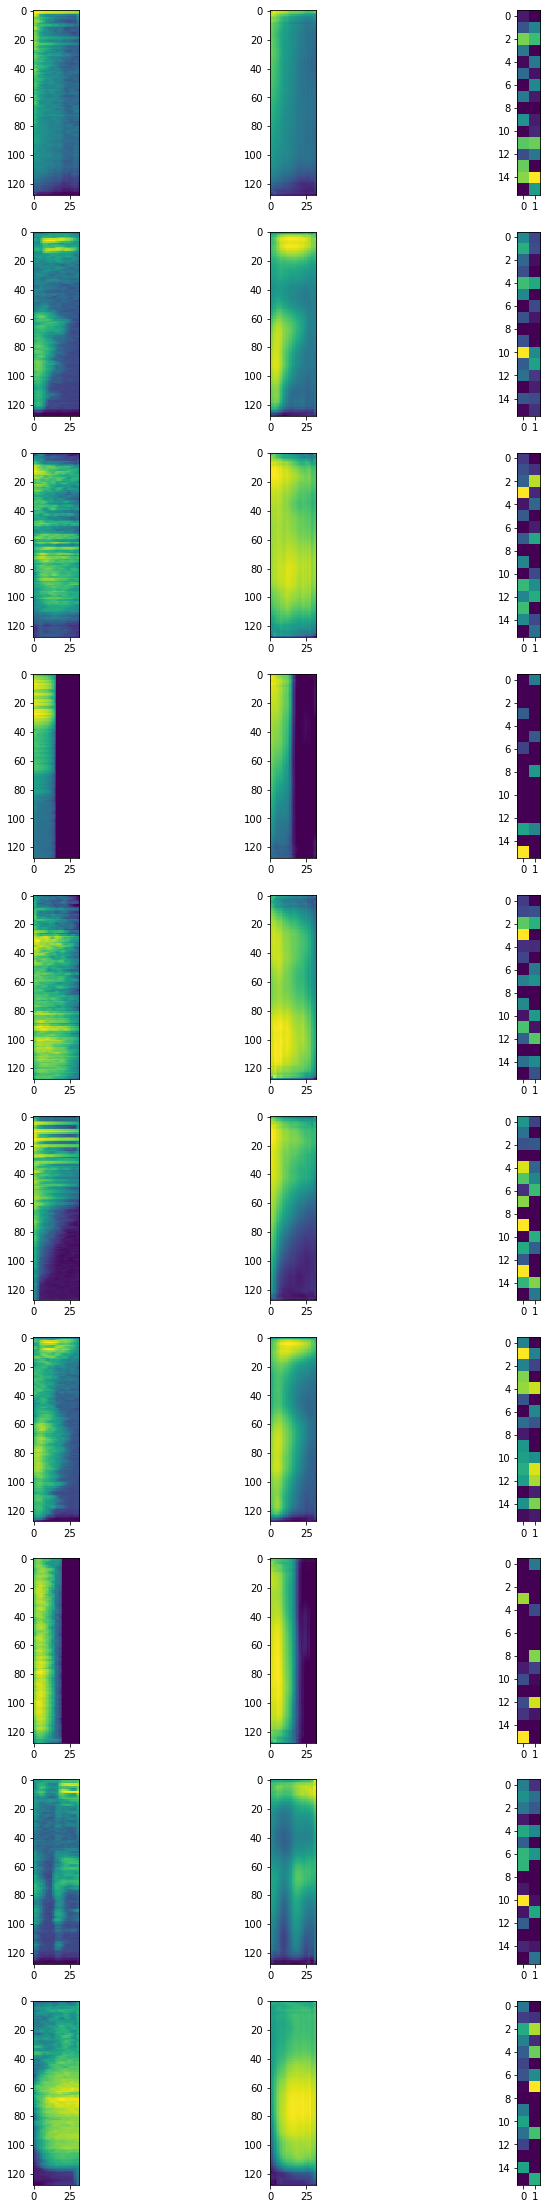

In [14]:
model_wide.eval()
imshow_ae_output(model_wide, common_set, 10, random_seed=455)